In [1]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import torch

from inference import Inference

In [2]:
# Initialize the Inference class (to automatically load the VAE and Classifier)
inf = Inference()

# Random test data for testing
test_samples = ["B001RQGBGI", "ABC-12345-XY", "!!!INVALID!!!", "010"]

Using device: cuda


In [3]:
print("Testing filtering logic...")
mask = inf.filter_inference_list(test_samples, inf.data_filters)
for s, m in zip(test_samples, mask):
    status = "PASS" if m else "FAIL (Invalid Structure)"
    print(f"Input: {s:15} | Status: {status}")
valid_only = [test_samples[i] for i, m in enumerate(mask) if m]

Testing filtering logic...
Input: B001RQGBGI      | Status: PASS
Input: ABC-12345-XY    | Status: PASS
Input: !!!INVALID!!!   | Status: PASS
Input: 010             | Status: FAIL (Invalid Structure)


In [4]:
print("Looking at a padded output...")
test_str = "ABC-123-09"
padded = inf.data_creator.pad_truncate_data([test_str], inf.train_max_length, inf.char2idx)

print(f"Input String: {test_str}")
print(f"Padded Shape: {padded.shape} (Expected: (1, {inf.train_max_length}))")
print(f"Integer Sequence: {padded[0]}") # Should see 4 padded tokens
assert padded.shape == (1, inf.train_max_length), "Shape mismatch in preprocessing."

Looking at a padded output...
Input String: ABC-123-09
Padded Shape: (1, 14) (Expected: (1, 14))
Integer Sequence: [14 15 16  3  5  6  7  3  4 13  0  0  0  0]


In [5]:
print("Testing VAE feature extraction...")
score_vector, debug_info = inf.extract_features_inference(valid_only, inf.vae)
for original, decoded in zip(valid_only, debug_info['reconstructions']):
    print(f"Original: {original}")
    print(f"VAE Reconstruction: {decoded}")

print(f"\nScore Vector Shape: {score_vector.shape} (Expected [N, 133])")
print(f"Sample Score Vector (Raw): {score_vector[0].cpu().numpy()}")

print("Testing encoder consistency...")
score1, _ = inf.extract_features_inference(["ABC-1234567"], inf.vae)
score2, _ = inf.extract_features_inference(["ABC-1234567"], inf.vae)
diff = torch.abs(score1 - score2).sum().item()
print(f"Difference between two identical runs: {diff:.10f}")
assert diff < 1e-6, "Model inconsistent. Check .eval() mode."

Testing VAE feature extraction...
Original: B001RQGBGI
VAE Reconstruction: B001RQGBGI
Original: ABC-12345-XY
VAE Reconstruction: ABC-12345-XY
Original: !!!INVALID!!!
VAE Reconstruction: <UNK><UNK><UNK>INVALID<UNK><UNK><UNK>

Score Vector Shape: torch.Size([3, 133]) (Expected [N, 133])
Sample Score Vector (Raw): [ 1.2269640e+00  4.6251154e+00  1.0931215e+00  1.6282973e+00
  3.1400516e+00 -7.7855444e-01  1.4939083e+00  2.9919713e+00
  2.1363685e+00 -3.9144346e-01 -1.4989313e+00 -7.5378996e-01
  2.5023575e+00  2.5170600e+00  5.7606345e-01 -1.1272787e+00
 -4.0722167e-01  3.0662858e+00 -6.3662988e-01  2.4180663e+00
  8.3774334e-01 -1.0294970e+00  1.1497620e+00  2.0346601e+00
  1.9508469e+00 -7.8690857e-01 -2.0529678e+00  6.7467433e-01
  2.4395978e+00  2.2893236e+00  8.8914829e-01 -5.3698385e-01
  1.3502423e+00  1.6323831e+00 -1.2028465e+00 -2.4319395e-01
 -1.3897835e+00  2.0574439e+00 -1.0468234e+00 -4.4993609e-01
  3.1341100e+00  1.2488689e+00 -1.8799751e+00  4.4361198e-01
 -3.7963068e-01 

Fixed a bug revealed in the above unit test: Same input gave different results. Upon further research, it turned out I was using the reparameterization method even during evaluation mode, which introduces random noise to the distribution. This is good for training so the model learns a latent space and not a single point, but makes the results non-deterministic for evaluation and inference.

RL and KL Divergence scores seem to be far apart, normalization is required to make them comparable with the rest of the scores.

In [6]:
print("Testing score scaling & classification...")
scaled_scores = (score_vector - inf.mean) / (inf.std + 1e-7) # 1e-7 to prevent div by zero
print("Scaled Score Vector (Raw):", scaled_scores[0].cpu().numpy())
with torch.no_grad():
    logits = inf.classifier(scaled_scores).squeeze(-1)
    if logits.dim() == 0: logits = logits.unsqueeze(0)
    probs = torch.sigmoid(logits)

for s, p in zip(valid_only, probs):
    pred = "yes (valid)" if p >= 0.5 else "no (invalid)"
    print(f"ID: {s} | Prob: {p:.4f} | Prediction: {pred}")

Testing score scaling & classification...
Scaled Score Vector (Raw): [-2.0736356   1.828224    1.6345545   1.6857072   2.0402286  -0.96960646
  1.260987    2.094692    2.043662   -0.5978207  -1.426868   -0.957565
  1.5906413   1.8336796   0.73413354 -1.2607967  -0.63125426  1.9357774
 -1.2276021   1.8551214   0.9852239  -1.8060974   1.4524865   1.9638907
  1.4293944  -0.77275467 -1.9986941   1.0188552   2.1616437   2.2374213
  0.9380759  -0.9745392   1.0304012   1.704844   -1.676568   -0.49341336
 -1.7895821   1.7911497  -1.3853545  -0.6328639   2.089378    1.285727
 -2.3908195   0.55371356 -0.51994175 -1.8775591   1.5783837  -1.9884455
 -1.6143755  -1.7802118  -1.7800897   2.0632658  -1.7679968  -1.9662437
 -0.44972983 -1.6658992  -1.2694592   1.496544   -1.9676323  -1.8715895
 -0.9091156   0.19065164 -1.4611806   0.7642872  -2.060762    1.0265915
  1.0557852   0.86036354  0.06676119  0.9812698  -0.02905986  0.6587374
  0.78192556  0.42255226 -1.9368225   0.02777774  1.4287951   1.120

In [7]:
print("Testing batch independence...")
single_score, _ = inf.extract_features_inference([test_samples[0]], inf.vae)
batch_scores, _ = inf.extract_features_inference(test_samples, inf.vae)
diff = torch.abs(single_score[0] - batch_scores[0]).max().item() 
print(f"Batch vs Single independence max diff: {diff:.10f}")
assert diff < 1e-4, f"Batch performs differently. Max diff: {diff}"

Testing batch independence...
Batch vs Single independence max diff: 0.0000004768


In [8]:
print("Testing input signal sensitivity...")
clean_id = "ABC-1234567"
dirty_id = "ABC!1234567" # Replaced '-' with '!'
score_clean, _ = inf.extract_features_inference([clean_id], inf.vae)
score_dirty, _ = inf.extract_features_inference([dirty_id], inf.vae)
recon_jump = score_dirty[0, 0] - score_clean[0, 0]
print(f"Recon Error Jump after 1-char corruption: {recon_jump:.4f}") # Positive jump signals that the VAE successfully flagged the structural anomaly

Testing input signal sensitivity...
Recon Error Jump after 1-char corruption: -0.0057


Visualize the last training history...


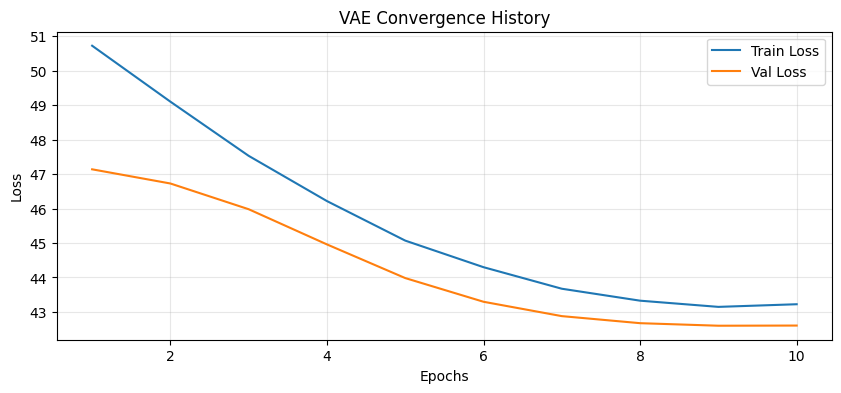

In [9]:
print("Visualize the last training history...")
log_path = os.path.join(inf.training_history, "local_logs", "vae_training_metrics.csv")
if os.path.exists(log_path):
    history = pd.read_csv(log_path)
    plt.figure(figsize=(10, 4))
    plt.plot(history['epoch'], history['train_loss'], label='Train Loss')
    plt.plot(history['epoch'], history['val_loss'], label='Val Loss')
    plt.title("VAE Convergence History")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Training log CSV not found. Re-run training.")